<a href="https://colab.research.google.com/github/jdescartes24/Storke-Prediction/blob/main/Stroke_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.***
# ***This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.***

# ***Goals***


1.   Explore the data to find insites to help better understand how health patterns in the data may determine if we have stroke
2.   Find a model that can accuratly predict if someone would have a stroke or not. 





In [43]:

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from matplotlib.pyplot import figure

In [44]:
df= pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [45]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## ***checking the Dtypes and getting an overall view of my data***

In [46]:
df.info()
# checking the Dtypes and getting an overall view of my data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# ***Checking for missing data***

In [47]:
# chceking for null values
df.isnull().sum()
# There are 201 values missing in the bmi column this will be taken care of later in the code with num selector strategey = Most Freques.

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# ***LOOKING INTO THE MISSING DATA***

In [48]:
#Getting the missing data to start analyzing
bmi_missing = df['bmi'].isna()

#Getting all the missing values and passing it into a new dataframe

x=df.loc[bmi_missing,:]

#calling that new dataframe
x

# Ther is no clear way to fill in the values just just looking for similarities in the given data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


# ***Checking to see how much of the patients with stoke that we would loose if we had to drop missing rows***

In [49]:
x['stroke'].value_counts()

#we were going to loose over 40 of our stroke patients if we were to drop these columns

0    161
1     40
Name: stroke, dtype: int64

# ***Creating a Function to help me check the calues of each of the columns in my data***

In [50]:
# cheking values of my columns to see if there are and miss spelling or out of place data
def values(x):
  x=df[x].value_counts()
  print(x)
values('gender')
values('ever_married')
values('work_type')
values('Residence_type')
values('smoking_status')
values('stroke')
# There were no inconsistances in my data 

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
0    4861
1     249
Name: stroke, dtype: int64


# ***Checking For duplicates, and droping them if found.***

In [51]:

# dropping all duplicates
df.drop_duplicates(inplace=True)

# ***Here I am droping the 'id' column, and the gender row  wich says other, because I believe they does not play a roll in predicting the data. Its just a random number applied to a patient.***

In [52]:
df.drop(columns= 'id', inplace= True)
df.drop(columns= 'work_type', inplace= True)
df.drop(columns= 'Residence_type', inplace= True)

df = df[df.gender != 'Other']
values('gender')

Female    2994
Male      2115
Name: gender, dtype: int64


# ***Creating a boxplot of the age columns***

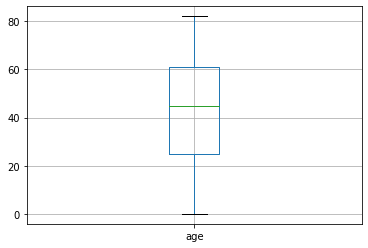

In [53]:
df.boxplot(column='age');
#looking at this boxplot we can see that the average age is50 years old.




# ***Creating a histogram of the age columns***

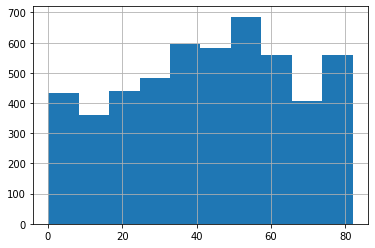

In [54]:
df['age'].hist();

# ***Creating a histogram of the hypertension column***

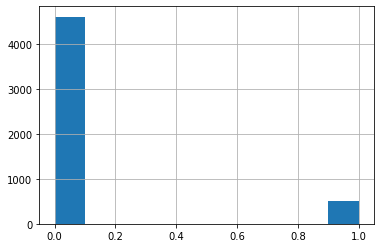

In [55]:
df['hypertension'].hist();

# ***Creating a histogram of the heart disease columns***

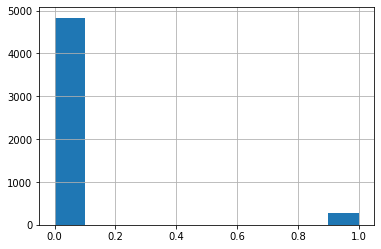

In [56]:
df['heart_disease'].hist();

# ***Creating a histogram of the ever married column***

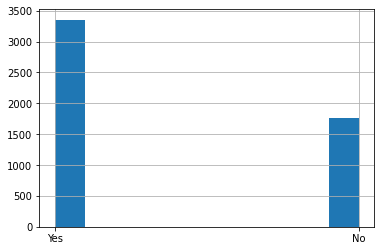

In [57]:
df['ever_married'].hist();

# ***Creating a histogram of the work type column***

# ***Creating a histogram of the average glucose level column***

AxesSubplot(0.125,0.125;0.775x0.755)


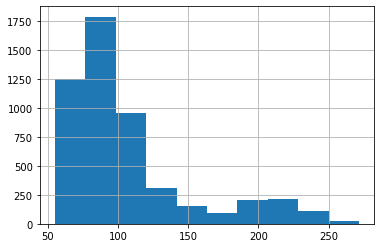

In [58]:
print(df['avg_glucose_level'].hist());


# ***Creating a boxplot of the average glucose level column***

AxesSubplot(0.125,0.125;0.775x0.755)


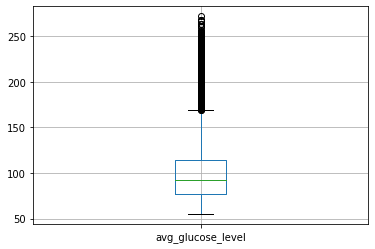

In [59]:
print(df.boxplot(column= 'avg_glucose_level'));

# ***Creating a histogram of the bmi level column***

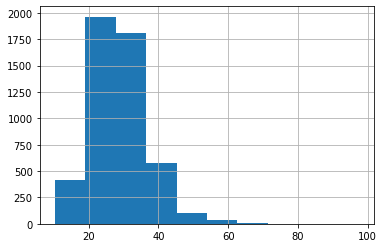

In [60]:
df['bmi'].hist();

# ***Creating a boxplot of the bmi level column***

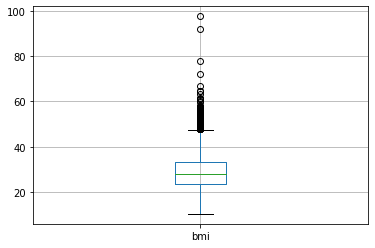

In [61]:
df.boxplot(column='bmi');

## ***Creating a histogram of the smoking status level column***

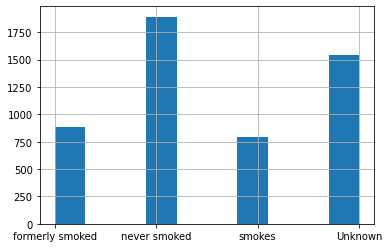

In [62]:
df['smoking_status'].hist();

# ***This Scatter plot using two columns , the average glucose levels and age of the patient to gain some insite on what type of patient is have a stroke.***

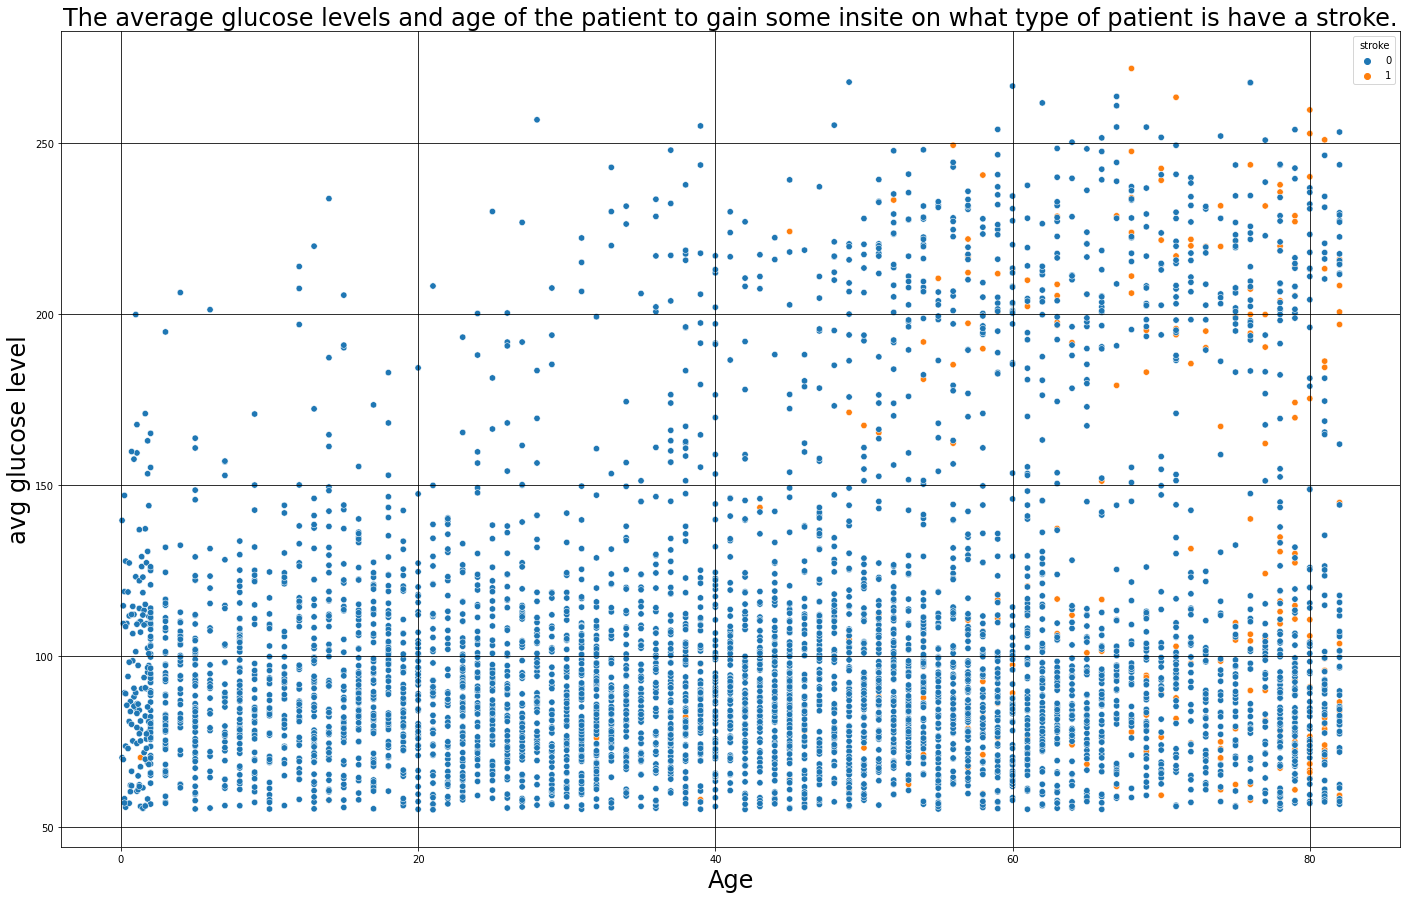

In [63]:
plt.figure(figsize= (24,15))

sns.scatterplot(data=df, x= 'age' , y= 'avg_glucose_level', hue= 'stroke', s=40);

plt.xlabel('Age',size=24);

plt.ylabel('avg glucose level',size=24);

plt.title('The average glucose levels and age of the patient to gain some insite on what type of patient is have a stroke.', size = 24);

plt.grid(c = 'Black')


# ***Creating a CoorRelation Heatmap of my data***

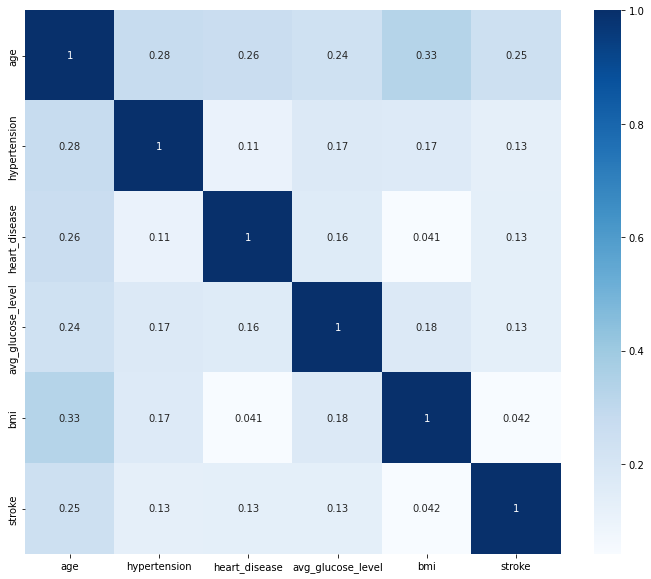

In [64]:
plt.figure(figsize= (12,10))

sns.heatmap(df.corr(), annot=True, cmap='Blues');
# There were no strong coorelations in this heat map.

# ***Exploring the data and asking questians***

In [65]:
#Isolating People with Stoke From People without stroke
stroke = df[df.stroke == 1]
No_stroke = df[df.stroke != 1]



# ***Is There any Correlation between people who had Stroke Vs People who did Not***

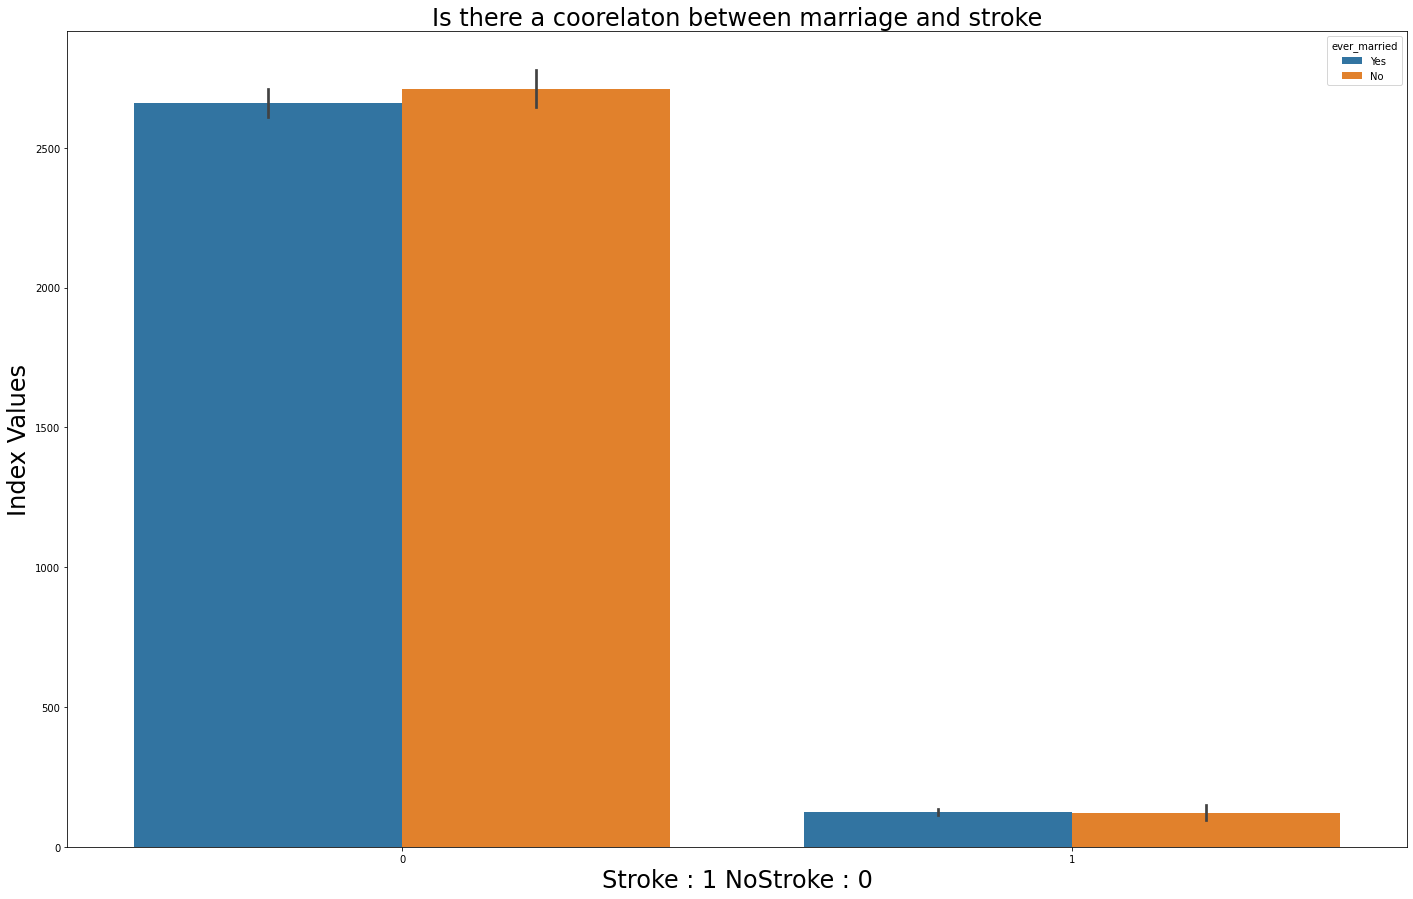

In [66]:
plt.figure(figsize= (24,15))

sns.barplot(data = df, y = df.index, x = 'stroke', hue= 'ever_married');

plt.xlabel('Stroke : 1 NoStroke : 0',size=24);

plt.ylabel('Index Values',size=24);

plt.title('Is there a coorelaton between marriage and stroke', size = 24);




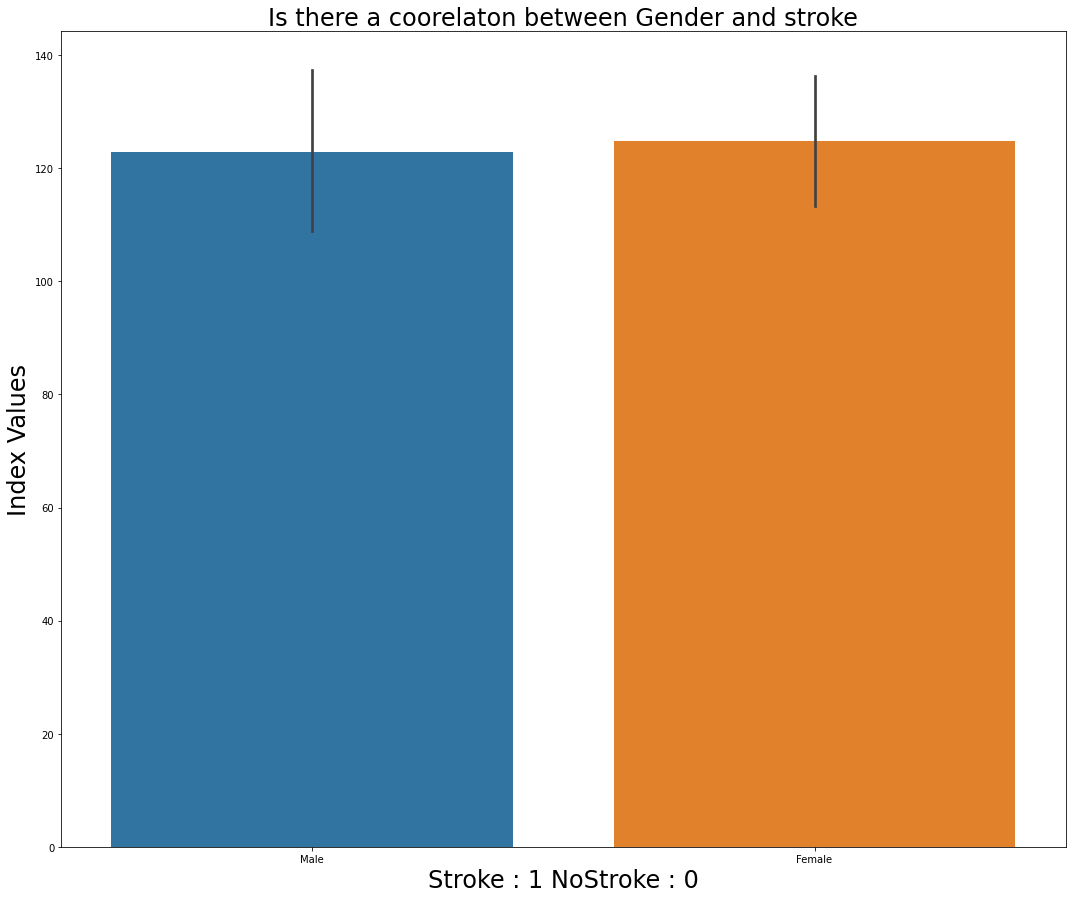

In [67]:
plt.figure(figsize= (18,15))

sns.barplot(data = stroke, y = stroke.index, x = 'gender');

plt.xlabel('Stroke : 1 NoStroke : 0',size=24);

plt.ylabel('Index Values',size=24);

plt.title('Is there a coorelaton between Gender and stroke', size = 24);

# ***Now I will be preparing my data for modeling***

In [68]:
# creating my target and features matrix.

X = df.drop(columns = 'stroke')

y = df['stroke']

In [69]:
from imblearn.over_sampling import RandomOverSampler
ovs = RandomOverSampler(random_state=42)
x_res, y_res = ovs.fit_resample(X, y)

In [70]:
# Creating my train test split
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, random_state = 42)

In [71]:
# as we contiune with preping our code, I will be making a out cat colum selectors.

# Selecting all the object data type columns and passing it to variable.
cat_col= make_column_selector(dtype_include = 'object')

# Selecting all the int columns and adding passing it to a variable.
num_col= make_column_selector(dtype_include= 'number')


In [72]:
# I choose median for filling in the missing values 
# Since there was no correlation between missing data a already filled data I decided to go with median to get back solid numbers that are practical .
median_imputer = SimpleImputer(strategy='mean')

In [73]:
# Making an instance of  standard scaler so I can use on our numerical values since the are not closly related.
scaler= StandardScaler()

# Making an instance of the one hot encoder, which will used on the rest of the numerical values for better performance of the model.
ohe = OneHotEncoder(handle_unknown= 'ignore', sparse= False)

In [74]:
cat_pipe = make_pipeline(ohe)

# Creating a num pipe to have the correct sequence for the transformation of columns
num_pipe = make_pipeline(median_imputer, scaler)

# Creating a tuple for my num pipe
num_tup = (num_pipe, num_col)

#- Creating a tuple for my cat pipe
cat_tup = (cat_pipe, cat_col)

# Making a instance of the column transform function and passing my tuples into them.

column_transfom = make_column_transformer( num_tup, cat_tup)

# ***Using the logistic regressor***

In [75]:
# Making an instance of the logistic Regressor
log_reg= LogisticRegression()

# now I will be creating a pipline to fit the logistic regressor onto the data
log_pipe= make_pipeline(column_transfom, log_reg)

# not fiting the pipe onto my data
log_pipe.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose.

# ***Hypertuning my model to Get the bets possible model***

In [76]:
# Getting parameters to hyper tune
log_pipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6d90>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer()),


In [77]:
# using a dictionary to make hyperparameters to test the data

param_grid = {'logisticregression__C': [1.0, 1.5,2,2.5],
              'logisticregression__penalty': ['l2','l1'],
              'logisticregression__solver': ['lbfgs','sag','saga']}

In [78]:
# isinstanciating the gridsearch model using my previous pipe and adding in the parameters
grid= GridSearchCV(log_pipe, param_grid)

# fitting the new grid sheach model on my training data
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                 

In [79]:
# Getting the  parameters that helped the model perform the best.
grid.best_params_

{'logisticregression__C': 1.0,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

# ***Getting Accuracy score***

In [80]:
# passing the trainig data accuracy score into a variable and then printing
Precision_Train_Score = accuracy_score(y_train, grid.predict(X_train))

print(f'The Accuracy train score is {Precision_Train_Score}')

# Passing the testing accuracy score into a variable and then printing it
Precision_Test_Score = accuracy_score(y_test, grid.predict(X_test))

print(f'The Accuracy test score is {Precision_Test_Score}')

The Accuracy train score is 0.7663923182441701
The Accuracy test score is 0.7958847736625514


# ***Getting Precision Score to see false positives on my logistic regressor model***

In [81]:
# Passing the testing precision score into a variable and then printing it
Precision_Test_Score = precision_score(y_test, grid.predict(X_test))

print(f'The precision test score is {Precision_Test_Score}')
# precision test score came back to be a 1 this may mean that the model is labeling everyone not to have stroke.

The precision test score is 0.7731800766283525


# ***Testing For Recall Score***

In [82]:
# Passing the testing recall score into a variable and then printing it
recall_Test_Score = recall_score(y_test, grid.predict(X_test))

print(f'The precision test score is {recall_Test_Score}')
# recall score came back low wich means there is a higher amount of false negatives

The precision test score is 0.8345740281224152


# ***extraacting raw confusion matrix data***

In [83]:
matrix=confusion_matrix(y_test, grid.predict(X_test))
matrix

array([[ 925,  296],
       [ 200, 1009]])

# ***Using the K Nearest neighbors on my data***

In [84]:
# Making an instance of the KNeighbours model
KNN= KNeighborsClassifier()

# now I will be creating a pipline to fit the KNN model onto the data
KNN_pipe= make_pipeline(column_transfom, KNN)

# not fiting the pipe onto my data
KNN_pipe.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose.

In [85]:
#getting the parameter to hypertune my model
KNN_pipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6d90>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer()),


# ***Hypertuning my KNN model using a grid search***

In [86]:
# using a dictionary to make hyperparameters to tet the data

knn_grid =  {'kneighborsclassifier__leaf_size':[2,3,5,10,15,20,30,40],
            'kneighborsclassifier__n_neighbors':[3,4,5,6,7,8],
            'kneighborsclassifier__p':[1,2],
            'kneighborsclassifier__weights':['distance','uniform']}

In [87]:
# isinstanciating the gridsearch model using my previous pipe and adding in the parameters
gridknn = GridSearchCV(KNN_pipe, knn_grid)

# fitting the new grid sheach model on my training data
gridknn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                 

In [88]:
gridknn.best_params_

{'kneighborsclassifier__leaf_size': 2,
 'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'distance'}

# ***Testing Accuracy score***

In [89]:
# passing the trainig data accuracy score into a variable and then printing
Precisionn_Score = accuracy_score(y_train, gridknn.predict(X_train))

print(f'The Accuracy train score is {Precisionn_Score}')

# Passing the testing accuracy score into a variable and then printing it
Precisions_Test_Score = accuracy_score(y_test, gridknn.predict(X_test))

print(f'The Accuracy test score is {Precisions_Test_Score}')

The Accuracy train score is 1.0
The Accuracy test score is 0.9592592592592593


# ***Testing Precision score***

In [90]:
# Passing the testing precision score into a variable and then printing it
Precision_Test_Score_knn = precision_score(y_test, gridknn.predict(X_test))

print(f'The precision test score is {Precision_Test_Score_knn}')
# this model has a higher rate of false positives

The precision test score is 0.9243119266055045


# ***Testing Recall score***

In [91]:
# Passing the testing precision score into a variable and then printing it
recall_Test_Score_knn = recall_score(y_test, gridknn.predict(X_test))

print(f'The recall test score is {recall_Test_Score_knn}')

The recall test score is 1.0


# ***Extracting a confusion matrix to better understand metrics***

In [92]:
matrix=confusion_matrix(y_test, gridknn.predict(X_test))
matrix

array([[1122,   99],
       [   0, 1209]])

# ***Now trying a gradient Boost to see if I can get better scores***

In [93]:
# Making an instance of the KNeighbours model
Boost= XGBClassifier()

# now I will be creating a pipline to fit the KNN model onto the data
Boost_pipe= make_pipeline(column_transfom, Boost)

# not fiting the pipe onto my data
Boost_pipe.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose.

In [94]:
#Getting parameter for m XGBCClassifier
Boost_pipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6d90>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer()),


In [95]:
# using a dictionary to make hyperparameters to tet the data

Boost_grid =  {'xgbclassifier__base_score':[0.1,0.3,0.5],
               'xgbclassifier__max_depth':[3,4,5,6],
               'xgbclassifier__n_jobs':[1,2,3,4],
               'xgbclassifier__n_estimators':[50,100,150,200]}

In [96]:
# isinstanciating the gridsearch model using my previous pipe and adding in the parameters
Boostknn = GridSearchCV(Boost_pipe, Boost_grid)

# fitting the new grid sheach model on my training data
Boostknn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7611a6850>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                 

# ***Testing Acuracy Score***

In [97]:
# Passing the testing accuracy score into a variable and then printing it
Acuracy_Test_ScoreBoost = accuracy_score(y_test, Boostknn.predict(X_test))

print(f'The Accuracy test score is {Acuracy_Test_ScoreBoost}')

The Accuracy test score is 0.9707818930041152


# ***Testing Precision Score***

In [98]:
# Passing the testing precision score into a variable and then printing it
Precision_Test_Score_Boost = precision_score(y_test, Boostknn.predict(X_test))

print(f'The precision test score is {Precision_Test_Score_Boost}')

The precision test score is 0.94453125


# ***Checking the recall score***

In [99]:
# Passing the testing precision score into a variable and then printing it
recall_Test_Score_Boost = precision_score(y_test, Boostknn.predict(X_test))

print(f'The recall test score is {recall_Test_Score_Boost}')

The recall test score is 0.94453125


## ***Extrtacing the confusion matrix***

In [100]:
matrix=confusion_matrix(y_test, Boostknn.predict(X_test))
matrix

array([[1150,   71],
       [   0, 1209]])

# The data model that I am going to go with is the Boost GRADIENT moDEL , the reason being is that it had 0  fasle nelgatives and the least amount of false . 

# This is great for diagnosing the patients and letting, o false negatives are great because they mean that know whoe is at risk will go without being diagnosed.



# ***Comparing the different models used with  confusion matrix viusalizations***

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

<Figure size 864x720 with 0 Axes>

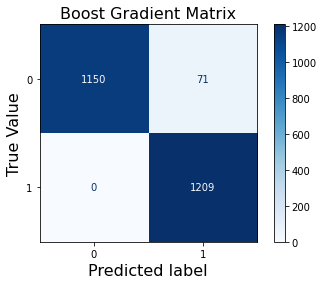

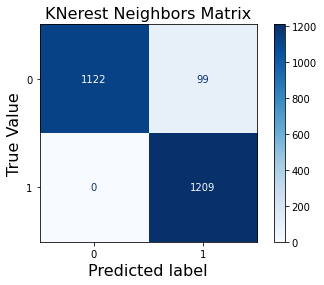

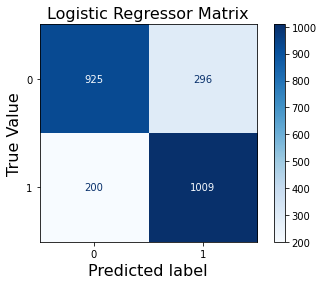

In [101]:
from sklearn.metrics import plot_confusion_matrix 
plt.figure(figsize= (12,10))

plot_confusion_matrix(Boostknn, X_test, y_test, cmap = 'Blues');
plt.title("Boost Gradient Matrix",fontsize = 16);
plt.xlabel('Predicted label',fontsize = 16);
plt.ylabel('True Value',fontsize = 16);

plot_confusion_matrix(gridknn, X_test, y_test, cmap = 'Blues');
plt.title("KNerest Neighbors Matrix",fontsize = 16);
plt.xlabel('Predicted label',fontsize = 16);
plt.ylabel('True Value',fontsize = 16);

plot_confusion_matrix(grid, X_test, y_test, cmap = 'Blues');
plt.title("Logistic Regressor Matrix",fontsize = 16);
plt.xlabel('Predicted label',fontsize = 16);
plt.ylabel('True Value',fontsize = 16);
